In [87]:
import re
import math

class Component:
    def __init__(self, name, comp_type, position):
        self.name = name
        self.type = comp_type
        self.position = position

    def __repr__(self):
        return f"{self.type}({self.name}) at {self.position}"

class Pad(Component):
    def __init__(self, name, position, radius):
        super().__init__(name, 'pad', position)
        self.radius = radius

    def __repr__(self):
        return f"Pad({self.name}, pos={self.position}, r={self.radius})"

class SquarePad(Component):
    def __init__(self, name, position, side_length, angle):
        super().__init__(name, 'square_pad', position)
        self.side_length = side_length
        self.angle = angle

    def __repr__(self):
        return f"SquarePad({self.name}, pos={self.position}, side={self.side_length}, angle={self.angle})"

    def get_corners(self):
        """
        回傳旋轉後的四個角座標。
        square_pad 是正方形，因此邊長相等。
        """
        cx, cy = self.position
        half_side = self.side_length / 2
        angle_rad = math.radians(self.angle)

        # 正方形在原點的四角
        corners = [
            (-half_side, -half_side),
            (-half_side, half_side),
            (half_side, half_side),
            (half_side, -half_side)
        ]

        # 旋轉並平移
        rotated = []
        for x, y in corners:
            x_rot = x * math.cos(angle_rad) - y * math.sin(angle_rad)
            y_rot = x * math.sin(angle_rad) + y * math.cos(angle_rad)
            rotated.append((cx + x_rot, cy + y_rot))

        return rotated

class RectPad(Component):
    def __init__(self, name, position, side_length, side_width, angle):
        super().__init__(name, 'rect_pad', position)
        self.side_length = side_length  # 長邊
        self.side_width = side_width    # 短邊
        self.angle = angle              # 旋轉角度（度數）

    def __repr__(self):
        return (f"RectPad({self.name}, pos={self.position}, "
                f"L={self.side_length}, W={self.side_width}, angle={self.angle})")

    def area(self):
        return self.side_length * self.side_width

    def get_corners(self):
        """
        回傳旋轉後的四個角座標，用於畫圖或碰撞檢測等。
        預設中心為 self.position，角度為 self.angle（度）
        """
        cx, cy = self.position
        l, w = self.side_length / 2, self.side_width / 2
        angle_rad = math.radians(self.angle)

        # 長方形四角在原點時的相對位置
        corners = [
            (-l, -w), (-l, w),
            (l, w), (l, -w)
        ]

        # 旋轉 + 平移
        rotated = []
        for x, y in corners:
            x_rot = x * math.cos(angle_rad) - y * math.sin(angle_rad)
            y_rot = x * math.sin(angle_rad) + y * math.cos(angle_rad)
            rotated.append((cx + x_rot, cy + y_rot))

        return rotated



class good_board:
    supported_list = {'wire', 'pad', 'square_pad', 'rect_pad'}

    def __init__(self, file):
        self.components = {}
        self.supported_list_activated = set()
        self.parse_file(file)

    def parse_file(self, file):
        with open(file, "r") as fo:
            for line in fo:
                line = line.strip()
                if not line:
                    continue
                try:
                    name, rest = line.split(":")
                    name = name.strip()
                    type_and_params = rest.split(",", 1)
                    comp_type = type_and_params[0].strip()

                    if comp_type not in self.supported_list:
                        print(f"Unsupported component type: {comp_type}")
                        continue

                    self.supported_list_activated.add(comp_type)

                    if comp_type == 'pad':
                        match = re.match(r"\s*\(([^)]+)\)\s*,\s*(.+)", type_and_params[1])
                        if not match:
                            raise ValueError("Invalid pad format")
                        pos_str, radius_str = match.groups()
                        x, y = map(float, pos_str.split(","))
                        radius = float(radius_str)
                        self.components[name] = Pad(name, (x, y), radius)

                    elif comp_type == 'square_pad':
                        match = re.match(r"\s*\(([^)]+)\)\s*,\s*([-\d.]+)\s*,\s*([-\d.]+)", type_and_params[1])
                        if not match:
                            raise ValueError("Invalid square_pad format")
                        pos_str, side_str, angle_str = match.groups()
                        x, y = map(float, pos_str.split(","))
                        side = float(side_str)
                        angle = float(angle_str)
                        self.components[name] = SquarePad(name, (x, y), side, angle)

                    elif comp_type == 'rect_pad':
                        match = re.match(r"\s*\(([^)]+)\)\s*,\s*([-\d.]+)\s*,\s*([-\d.]+)\s*,\s*([-\d.]+)", type_and_params[1])
                        if not match:
                            raise ValueError("Invalid rect_pad format")
                        pos_str, l_str, w_str, angle_str = match.groups()
                        x, y = map(float, pos_str.split(","))
                        l = float(l_str)
                        w = float(w_str)
                        angle = float(angle_str)
                        self.components[name] = RectPad(name, (x, y), l, w, angle)

                except Exception as e:
                    print(f"Failed to parse line: '{line}', error: {e}")

    def check_collision(self, obj1, obj2):
        t1 = obj1.type
        t2 = obj2.type

        # 用 tuple 做類型對應（不區分順序）
        type_pair = tuple(sorted([t1, t2]))

        if type_pair == ('pad', 'pad'):
            return self._collision_circle_circle(obj1, obj2)
        elif 'pad' in type_pair and 'rect_pad' in type_pair:
            return self._collision_circle_polygon(obj1, obj2)
        elif 'pad' in type_pair and 'square_pad' in type_pair:
            return self._collision_circle_polygon(obj1, obj2)
        elif t1 in {'rect_pad', 'square_pad'} and t2 in {'rect_pad', 'square_pad'}:
            return self._collision_polygon_polygon(obj1, obj2)
        elif 'wire' in type_pair:
            return self._collision_with_wire(obj1, obj2)
        else:
            raise NotImplementedError(f"Collision detection not implemented for: {type_pair}")

    # === 圓形-圓形碰撞 ===
    def _collision_circle_circle(self, c1, c2):
        dx = c1.position[0] - c2.position[0]
        dy = c1.position[1] - c2.position[1]
        distance = (dx ** 2 + dy ** 2) ** 0.5
        return distance <= c1.radius + c2.radius

    # === 圓形-多邊形（SAT） ===
    def _collision_circle_polygon(self, circle_obj, poly_obj):
        if circle_obj.type not in {'pad'}:
            circle_obj, poly_obj = poly_obj, circle_obj  # swap

        circle = circle_obj
        poly = poly_obj
        corners = poly.get_corners()
        # axes = self._get_axes(corners)
        axes = [] # https://github.com/phenomLi/Blog/issues/23
        
        # 加入從圓心指向最近角點的軸 <- 這啥邏輯
        closest = min(corners, key=lambda p: (p[0]-circle.position[0])**2 + (p[1]-circle.position[1])**2)
        axis_to_circle = (closest[0] - circle.position[0], closest[1] - circle.position[1])
        axes.append(axis_to_circle) # <- circle和多邊形只需要測試一條分離軸
        
        for axis in axes:
            proj1 = self._project_polygon(corners, axis)
            proj2 = self._project_circle(circle.position, circle.radius, axis)
            if proj1[1] < proj2[0] or proj2[1] < proj1[0]:
                return False
        return True

    # === 多邊形-多邊形 ===
    def _collision_polygon_polygon(self, p1, p2):
        c1 = p1.get_corners()
        c2 = p2.get_corners()
        axes = self._get_axes(c1) + self._get_axes(c2) # <- 這個 '+' 是 python list的 '+'
        for axis in axes:
            """
            在一次iteration裡面, axis的值是固定的:
            proj1 = self._project_polygon(c1, axis) <- 把一號多邊形的corner點們都投影到這個軸上面
            proj2 = self._project_polygon(c2, axis) <- 一樣

            這個軸是一條直線, 數學表示是y = ax + b, 但!!! b是誰不重要, 簡而言之: 可以投影到任一條斜率為a的直線上去
            """
            proj1 = self._project_polygon(c1, axis) # proj1是一個tuple, (a, b) <- a是起點, b是終點
            proj2 = self._project_polygon(c2, axis)
            if proj1[1] < proj2[0] or proj2[1] < proj1[0]: # 這是啥測試條件?? 如果proj1這個"線段"的終點小於proj2的起點, 代表兩個線段中間有gap阿! 根據S.A.T.兩個物體兩個object必然沒有碰撞
                return False
        return True

    # === 處理 wire ===
    def _collision_with_wire(self, obj1, obj2):
        # 這裡你可以擴展具體邏輯，例如 wire 的中段不能碰
        print("WARNING: wire collision logic not yet implemented")
        return False

    # === 工具：取得邊的法向量 ===
    def _get_axes(self, corners):
        axes = []
        for i in range(len(corners)):
            p1 = corners[i] # <- p1是point1的意思
            p2 = corners[(i + 1) % len(corners)]
            edge = (p2[0] - p1[0], p2[1] - p1[1]) # <- 這行在幹嘛? p1, p2都是一個tuple阿!!
            normal = (-edge[1], edge[0]) # <- normal怎麼取的?就是斜率相乘 == -1呀
            axes.append(normal)
        return axes

    # === 工具：投影多邊形 === <- 講白了就是投影
    def _project_polygon(self, corners, axis): 
        dot = lambda p: p[0]*axis[0] + p[1]*axis[1]
        dots = [dot(p) for p in corners]
        return min(dots), max(dots) # <- min(dots) 和 max(dots) 就是這段影子的左右端點

    # === 工具：投影圓形 ===
    def _project_circle(self, center, radius, axis):
        # 單位向量化
        length = (axis[0]**2 + axis[1]**2)**0.5
        norm_axis = (axis[0]/length, axis[1]/length)
        center_proj = center[0]*norm_axis[0] + center[1]*norm_axis[1]
        return center_proj - radius, center_proj + radius
    def __str__(self):
        return "\n".join(str(c) for c in self.components.values())


No collision detected.


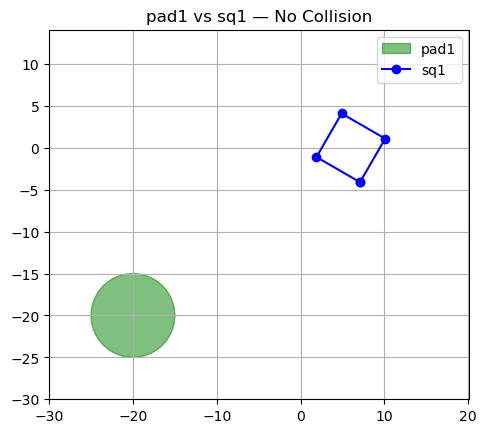

In [91]:
import matplotlib.pyplot as plt

# === 建立測試元件 ===
pad1 = Pad("pad1", (-20, -20), 5)
square1 = SquarePad("sq1", (6, 0), 6, 60)  # 調整位置改變碰撞狀態

# === 建立 board 並測試碰撞 ===
board = good_board("foo.txt")  # 可以給任何 dummy filename，不會用到
board.components = {"pad1": pad1, "sq1": square1}  # 手動加元件

collision = board.check_collision(pad1, square1)
print("Collision detected:" if collision else "No collision detected.")

# === 畫圖顯示 ===
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid(True)
ax.set_title(f"pad1 vs sq1 — {'Collision' if collision else 'No Collision'}")

# 畫 pad (紅色圓形)
circle_color = 'red' if collision else 'green'
circle = plt.Circle(pad1.position, pad1.radius, color=circle_color, alpha=0.5, label="pad1")
ax.add_patch(circle)

# 畫 square_pad (藍色方形)
square_corners = square1.get_corners()
square_corners.append(square_corners[0])  # 封閉回起點
xs, ys = zip(*square_corners)
ax.plot(xs, ys, 'b-o', label="sq1")

# 調整畫布範圍
all_x = [pad1.position[0]] + list(xs)
all_y = [pad1.position[1]] + list(ys)
ax.set_xlim(min(all_x)-10, max(all_x)+10)
ax.set_ylim(min(all_y)-10, max(all_y)+10)

plt.legend()
plt.show()


❌ No collision.


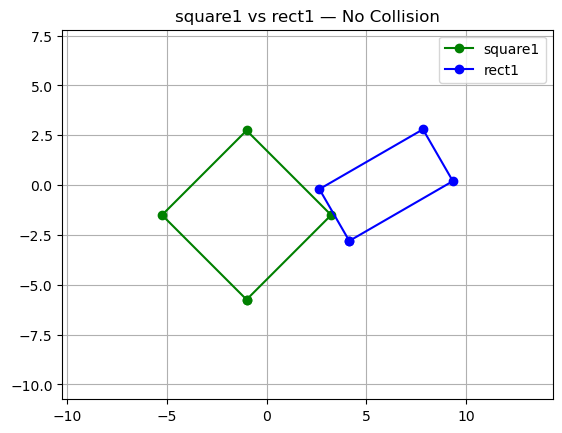

In [53]:
import matplotlib.pyplot as plt

# === 建立元件 ===
square1 = SquarePad("sq1", position=(-1, -1.5), side_length=6, angle=45)
rect1 = RectPad("rect1", position=(6, 0), side_length=6, side_width=3, angle=30)

# 建立 board 實例
board = good_board("foo.txt")  # 不讀檔，直接塞進元件
board.components = {"sq1": square1, "rect1": rect1}

# === 碰撞檢查 ===
collision = board.check_collision(square1, rect1)
print("✅ Collision detected!" if collision else "❌ No collision.")

# === 畫圖展示 ===
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid(True)
ax.set_title(f"square1 vs rect1 — {'Collision' if collision else 'No Collision'}")

# 畫 square_pad
sq_corners = square1.get_corners()
sq_corners.append(sq_corners[0])
xs1, ys1 = zip(*sq_corners)
ax.plot(xs1, ys1, 'green' if not collision else 'red', marker='o', label="square1")

# 畫 rect_pad
rect_corners = rect1.get_corners()
rect_corners.append(rect_corners[0])
xs2, ys2 = zip(*rect_corners)
ax.plot(xs2, ys2, 'blue', marker='o', label="rect1")

# 畫布邊界自動調整
all_x = list(xs1) + list(xs2)
all_y = list(ys1) + list(ys2)
ax.set_xlim(min(all_x) - 5, max(all_x) + 5)
ax.set_ylim(min(all_y) - 5, max(all_y) + 5)

plt.legend()
plt.show()


In [55]:
a = [1, 2]
b = [3, 4]
a + b

[1, 2, 3, 4]